In [1]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.sparse import kron, identity, csr_matrix, lil_matrix
from scipy.sparse.linalg import eigsh, eigs
from scipy.optimize import curve_fit
from qutip import Qobj, ptrace
from tqdm import tqdm
from itertools import product
from functools import reduce
import torch
import torch.optim as optim

In [2]:
def pauli_x():
    """Pauli X matrix."""
    return np.array([[0, 1], [1, 0]])

def pauli_z():
    """Pauli Z matrix."""
    return np.array([[1, 0], [0, -1]])

def icosahedral_bonds(): #12 vertices
    """
    Defines the connectivity of a true 12-vertex icosahedral molecular structure.
    
    Returns:
        list of tuples: Each tuple (i, j) represents a bond between spin i and spin j.
    """
    bonds = [
        (0, 2), (0, 4), (0, 5), (0, 8), (0, 9),
        (1, 3), (1, 6), (1, 7), (1, 10), (1, 11),
        (2, 6), (2, 7), (2, 8), (2, 9), (3, 4),
        (3, 5), (3, 10), (3, 11), (4, 5), (4, 8),
        (4, 10), (5, 9), (5, 11), (6, 7), (6, 8),
        (6, 10), (7, 9), (7, 11), (8, 10), (9, 11)
    ]
    return bonds


def transverse_field_ising_icosahedral(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model on an icosahedral molecular structure.
    
    Parameters:
        N (int): Number of spins (should match the icosahedral molecule, typically N=20).
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (scipy.sparse.csr_matrix): The Hamiltonian matrix in sparse format.
    """
    if N != 12:
        raise ValueError("Icosahedral molecules typically have N = 12 sites.")

    # Sparse identity matrix
    I = identity(2, format="csr")
    
    # Pauli matrices as sparse matrices
    X = csr_matrix(pauli_x())
    Z = csr_matrix(pauli_z())
    
    # Initialize the Hamiltonian
    H = csr_matrix((2**N, 2**N), dtype=np.float64)
    
    # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def transverse_field_ising_icosahedral_dense(N, J, h):
    """
    Constructs the Hamiltonian for the transverse field Ising model in dense format.
    
    Parameters:
        N (int): Number of spins.
        J (float): Interaction strength.
        h (float): Transverse field strength.
    
    Returns:
        H (np.ndarray): The Hamiltonian matrix in dense format.
    """
    # Pauli matrices
    X = pauli_x()
    Z = pauli_z()
    I = np.eye(2)
    
    # Initialize the Hamiltonian
    H = np.zeros((2**N, 2**N), dtype=np.float64)

     # Get icosahedral bonds
    bonds = icosahedral_bonds()
    
    # Interaction term: -J * sigma_i^x * sigma_j^x for icosahedral connectivity
    for i, j in bonds:
        term = 1
        for k in range(N):
            if k == i or k == j:
                term = kron(term, X, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += J * term
    
    # Transverse field term: -h * sigma_i^z
    for i in range(N):
        term = 1
        for j in range(N):
            if j == i:
                term = kron(term, Z, format="csr")
            else:
                term = kron(term, I, format="csr")
        H += -h * term
    
    return H

def entanglement_entropy(psi, subsystem_size, total_size): #naive system bipartition - does it work  for  icosahedron?
    """
    Computes the bipartite entanglement entropy of a pure state.
    
    Parameters:
    psi : np.array
        The wavefunction (state vector) of the full system.
    subsystem_size : int
        The number of qubits in subsystem A.
    total_size : int
        The total number of qubits in the system.
    
    Returns:
    float
        The von Neumann entanglement entropy S_A.
    """
    # Calculate the size of the environment
    environment_size = total_size - subsystem_size
    
    # Reshape psi into a 2^subsystem_size x 2^environment_size matrix
    psi_matrix = psi.reshape((2**subsystem_size, 2**environment_size))
    
    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho_A = np.dot(psi_matrix, psi_matrix.conj().T)  # Partial trace over B
    
    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero eigenvalues to avoid numerical issues in log calculation
    eigenvalues = eigenvalues[eigenvalues > 0]
    
    # Compute von Neumann entropy S_A = -Tr(rho_A log rho_A)
    entropy = -np.sum(eigenvalues * np.log2(eigenvalues))
    
    return entropy

# Define the entanglement entropy function
def entanglement_entropy_torch(psi, N_half, N):
    # Reshape psi to a 2D tensor for partial trace
    psi = psi.view(2**N_half, 2**N_half)
    
    # Compute the reduced density matrix rho_A = Tr_B(|psi><psi|)
    rho = torch.matmul(psi, psi.conj().t())
    eigvals = torch.linalg.eigvalsh(rho)
    eigvals = eigvals[eigvals > 1e-16]
    entropy = -torch.sum(eigvals * torch.log(eigvals + 1e-12))
    return entropy

# Define the linear combination function
def linear_combination(coeffs, psis):
    # Ensure psis are PyTorch tensors
    psis_torch = [torch.tensor(psi, dtype=torch.complex64) if not isinstance(psi, torch.Tensor) else psi for psi in psis]
    
    # Compute the linear combination in PyTorch
    psi_torch = sum(c * psi for c, psi in zip(coeffs, psis_torch))
    
    return psi_torch

# Define the linear combination function
def linear_combination_np(coeffs, psis):
    # Ensure psis are numpy tensors
    psi_np = [np.array(psi) for psi in psis]
    # Compute the linear combination in PyTorch
    psi = sum(c * psi for c, psi in zip(coeffs, psis))
    
    return psi

In [3]:
N = 12  # Number of spins
J = 1.0  # Interaction strength
h = 3.0  # Transverse field strength # this is the value in the paper. maybe try  other values too, including the critical value one (h=J=1)

# Assuming transverse_field_ising is defined and returns a sparse Hermitian matrix
H = transverse_field_ising_icosahedral(N, J, h)

#print(f"Hamiltonian shape: {H.shape}")
#print(f"Non-zero elements in H: {H.nnz}")

In [4]:
# ground state of H only + debugging partial trace

# Compute smallest eigenvalue and the corresponding eigenvector
min_eigenvalue, min_eigenvector = eigsh(H, k=1, which='SA')

print(f"Minimum eigenvalue: {min_eigenvalue}")
print(f"Corresponding eigenvector shape: {min_eigenvector.shape}")
#print(f"Corresponding eigenvector: {min_eigenvector}")

#Construct the density matrix
density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())

print(f"Density matrix shape: {density_matrix.shape}")
#print(f"Density matrix: {density_matrix}")

density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])
print(f"qobj density matrix shape: {density_matrix_qobj.shape}")
#print(f"qobj density matrix: {density_matrix_qobj}")

# Trace out some qubits (keep other qubits)
keep_qubits = [0,2,8]  # triangular plaquette
traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

# Convert the result back to a dense matrix if needed
traced_out_density_matrix_dense = traced_out_density_matrix.full()

print(type(traced_out_density_matrix))
print(type(traced_out_density_matrix_dense))

print(f"Traced out density matrix shape: {traced_out_density_matrix_dense.shape}")
#print(f"Traced out density matrix: {traced_out_density_matrix_dense}")

# Diagonalize the traced out density matrix
to_eigenvalues, to_eigenvectors = np.linalg.eigh(traced_out_density_matrix_dense)
#print(f"Eigenvalues of the traced out density matrix: {eigenvalues}")
#print(f"Eigenvectors of the traced out density matrix: {eigenvectors}")

# Print the minimum eigenvalue
min_eigenvalue = np.min(to_eigenvalues)
print(f"Minimum eigenvalue: {min_eigenvalue}")

Minimum eigenvalue: [-37.9456425]
Corresponding eigenvector shape: (4096, 1)
Density matrix shape: (4096, 4096)
qobj density matrix shape: (4096, 4096)
<class 'qutip.core.qobj.Qobj'>
<class 'numpy.ndarray'>
Traced out density matrix shape: (8, 8)
Minimum eigenvalue: 1.6972163951808958e-06


In [5]:
# All eigenvalues of H
# Compute all eigenvalues and corresponding eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H.toarray())

print(f"Eigenvalues of H: {np.sort(eigenvalues)}")

Eigenvalues of H: [-37.9456425  -33.85228906 -33.85228906 ...  36.38287836  40.95956435
  41.28675302]


In [6]:
'''#debugging, checking 3 spins rdm + comparison to paper

min_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out qubits
    keep_qubits = [0, 2, 8]  # triangular plaquette
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Print the rank of the traced out density matrix
    rank = np.linalg.matrix_rank(traced_out_density_matrix)
    #print(f"Eigenvector {i}: Rank of traced out density matrix: {rank}")

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced),
    min_eigenvalues.append(min_eigenvalue)

print("Minimum eigenvalues of the traced-out density matrix:", np.sort(min_eigenvalues))'''

'#debugging, checking 3 spins rdm + comparison to paper\n\nmin_eigenvalues = []\n\nfor i in tqdm(range(len(eigenvalues))):\n    # Construct the density matrix for each eigenvector\n    min_eigenvector = eigenvectors[:, i]\n    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())\n    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])\n\n    # Trace out qubits\n    keep_qubits = [0, 2, 8]  # triangular plaquette\n    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)\n\n    # Convert the result back to a dense matrix if needed\n    traced_out_density_matrix_dense = traced_out_density_matrix.full()\n\n    # Print the rank of the traced out density matrix\n    rank = np.linalg.matrix_rank(traced_out_density_matrix)\n    #print(f"Eigenvector {i}: Rank of traced out density matrix: {rank}")\n\n    # Diagonalize the traced-out density matrix\n    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)\n\n    # Find the minimum eige

In [7]:
'''# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H

min_eigenvalues = np.array(min_eigenvalues)

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, min_eigenvalues, s=1)

# Set y-scale to log and manually define the ticks
plt.yscale("log")
#lt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel(r"$\lambda_{\text{min}}$ of rdm")
# plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()'''

'# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H\n\nmin_eigenvalues = np.array(min_eigenvalues)\n\n# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H\nplt.scatter(eigenvalues, min_eigenvalues, s=1)\n\n# Set y-scale to log and manually define the ticks\nplt.yscale("log")\n#lt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])\n\nplt.xlabel(\'Eigenvalue of Hamiltonian H\')\nplt.ylabel(r"$\\lambda_{\text{min}}$ of rdm")\n# plt.title(\'Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H\')\nplt.show()'

In [8]:
'''#  Mid 100 eigenvalues of H, 4/5 spins rdm

# Compute 100 smallest eigenvalues and the corresponding eigenvectors
eigenvalues, eigenvectors = eigsh(H, k=100, which='BE')

min_eigenvalues = []

for i in tqdm(range(100)):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out some qubits (keep other qubits)
    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced)
    min_eigenvalues.append(min_eigenvalue)

print("Minimum eigenvalues of the traced-out density matrix:", np.sort(min_eigenvalues))'''

'#  Mid 100 eigenvalues of H, 4/5 spins rdm\n\n# Compute 100 smallest eigenvalues and the corresponding eigenvectors\neigenvalues, eigenvectors = eigsh(H, k=100, which=\'BE\')\n\nmin_eigenvalues = []\n\nfor i in tqdm(range(100)):\n    # Construct the density matrix for each eigenvector\n    min_eigenvector = eigenvectors[:, i]\n    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())\n    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])\n\n    # Trace out some qubits (keep other qubits)\n    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes\n    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)\n\n    # Convert the result back to a dense matrix if needed\n    traced_out_density_matrix_dense = traced_out_density_matrix.full()\n\n    # Diagonalize the traced-out density matrix\n    eigenvalues_traced, _ = np.linalg.eigh(traced_out_density_matrix_dense)\n\n    # Find the minimum eigenvalue of the traced-out density matrix\n    m

In [9]:
'''# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.plot(eigenvalues, min_eigenvalues, 'o', markersize=2)

# Set y-scale to log and manually define the ticks
plt.yscale("log")
#plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel('Minimum eigenvalue of traced-out density matrix')
#plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()'''

'# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H\nplt.plot(eigenvalues, min_eigenvalues, \'o\', markersize=2)\n\n# Set y-scale to log and manually define the ticks\nplt.yscale("log")\n#plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])\n\nplt.xlabel(\'Eigenvalue of Hamiltonian H\')\nplt.ylabel(\'Minimum eigenvalue of traced-out density matrix\')\n#plt.title(\'Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H\')\nplt.show()'

In [10]:
# 4/5 spins rdm

min_eigenvalues = []
min_rdms =[]
rdm_eigenvalues = []

for i in tqdm(range(len(eigenvalues))):
    # Construct the density matrix for each eigenvector
    min_eigenvector = eigenvectors[:, i]
    density_matrix = np.outer(min_eigenvector, min_eigenvector.conj())
    density_matrix_qobj = Qobj(density_matrix, dims=[[2]*N, [2]*N])

    # Trace out qubits
    #keep_qubits = [2, 8, 4, 5, 9] # pentagon around 0
    keep_qubits = [0, 4, 5, 9]  # 2 adjacent triangular plaquettes
    traced_out_density_matrix = ptrace(density_matrix_qobj, keep_qubits)

    # Convert the result back to a dense matrix if needed
    traced_out_density_matrix_dense = traced_out_density_matrix.full()

    # Diagonalize the traced-out density matrix
    eigenvalues_traced, eigenvectors_traced = np.linalg.eigh(traced_out_density_matrix_dense)

    # Find the minimum eigenvalue of the traced-out density matrix
    min_eigenvalue = np.min(eigenvalues_traced) 
    min_eigenvalues.append(min_eigenvalue)

    if min_eigenvalue < 1e-16:
        min_rdms.append(traced_out_density_matrix_dense) #store the scarred rdms - step needed for optimization
        rdm_eigenvalues.append(eigenvalues_traced)

100%|██████████| 4096/4096 [21:45<00:00,  3.14it/s]


In [61]:
# print rdm rank + rdm + rdm eigenvalues for non scarred points - p.e. last state in the for loop

print(eigenvalues_traced)

print(np.linalg.matrix_rank(traced_out_density_matrix_dense) )

# Count entries of eigenvalues_traced that are greater than 1e-16
countf = np.sum(eigenvalues_traced > 1e-16)
print(countf)

# rank is full - 16 for 4 spins or 32 for 5 spins

[2.52072748e-07 2.71824234e-07 1.13261257e-06 1.49306310e-06
 2.59526365e-06 2.03905777e-05 6.00362121e-05 9.29651824e-05
 1.58486100e-04 2.23574437e-04 2.58846360e-04 2.05605176e-03
 3.40451665e-03 4.96257249e-03 3.10970240e-01 6.77786576e-01]
16
16


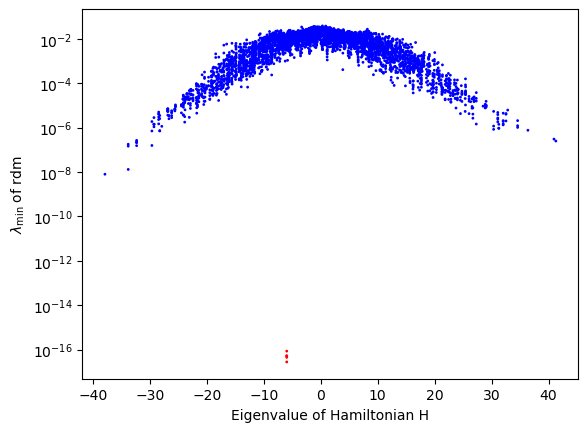

In [62]:
# Define the threshold
threshold = 1e-16
min_eigenvalues = np.array(min_eigenvalues)

# Count points with y-component less than the threshold
count = sum(1 for y in min_eigenvalues if y < threshold)

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues]

# Plot the minimum eigenvalue of the traced-out density matrix as a function of the eigenvalue of the Hamiltonian H
plt.scatter(eigenvalues, np.abs(min_eigenvalues), color=colors, s=1)

# Set y-scale to log and manually define the ticks
#plt.yscale("log")
# plt.yticks([10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1], [r"$10^{-6}$", r"$10^{-5}$", r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$"])

plt.xlabel('Eigenvalue of Hamiltonian H')
plt.ylabel(r"$\lambda_{\text{min}}$ of rdm")
plt.yscale("log")
#plt.xlim(5,10)
#plt.ylim(10**-19, 10**-16)
# plt.title('Minimum eigenvalue of traced-out density matrix vs Eigenvalue of Hamiltonian H')
plt.show()

In [63]:
print(f'Number of points with y-component less than {threshold}: {count}')

# Find indices of red points
red_indices = [i for i, y in enumerate(min_eigenvalues) if y < threshold]
print(f'Indices of red points: {red_indices}')

red_eigenvectors = []

# Print eigenvalues, RDM minimum eigenvalues, and scalar products of eigenvectors for red points
for i,ind in enumerate(red_indices):
    print(i, ind)
    print(f'Eigenvalue: {eigenvalues[ind]}, rdm Minimum Eigenvalue: {min_eigenvalues[ind]}')
    print(f'Eigenvector {ind}: rdm rank: {np.linalg.matrix_rank(min_rdms[i])}')
    red_eigenvectors.append(eigenvectors[:, ind])

for i in range(len(red_indices)):
    for j in range(len(red_indices)):
        idx1, idx2 = red_indices[i], red_indices[j]
        dot_product = np.dot(eigenvectors[:, idx1], np.conj(eigenvectors[:, idx2]))
        print(f"Dot product between eigenvectors {idx1} and {idx2}: {dot_product}")

# Count entries of rdm_eigenvalues[i] that are smaller than 1e-16
counts = [np.sum(eigenvalues > 1e-16) for eigenvalues in rdm_eigenvalues]
print(f'Counts of eigenvalues smaller than 1e-16: {counts}')

# rank is 16-5=11 for 4 spins or 32-5=27 for 5 spins

Number of points with y-component less than 1e-16: 5
Indices of red points: [1266, 1267, 1268, 1269, 1270]
0 1266
Eigenvalue: -6.000000000000003, rdm Minimum Eigenvalue: -5.068389397934375e-17
Eigenvector 1266: rdm rank: 11
1 1267
Eigenvalue: -6.0, rdm Minimum Eigenvalue: -2.7795075765071667e-17
Eigenvector 1267: rdm rank: 11
2 1268
Eigenvalue: -6.0, rdm Minimum Eigenvalue: -8.519229768198621e-17
Eigenvector 1268: rdm rank: 11
3 1269
Eigenvalue: -5.999999999999997, rdm Minimum Eigenvalue: -5.305424579531258e-17
Eigenvector 1269: rdm rank: 11
4 1270
Eigenvalue: -5.9999999999999964, rdm Minimum Eigenvalue: -4.475935646746779e-17
Eigenvector 1270: rdm rank: 11
Dot product between eigenvectors 1266 and 1266: 0.9999999999999998
Dot product between eigenvectors 1266 and 1267: -7.37257477290143e-17
Dot product between eigenvectors 1266 and 1268: 2.47198095326695e-17
Dot product between eigenvectors 1266 and 1269: 3.469446951953614e-17
Dot product between eigenvectors 1266 and 1270: -2.0816681

In [90]:
# Generate random complex coefficients
random_coeffs = np.random.rand(len(red_indices)) + 1j* np.random.rand(len(red_indices))

# Normalize the coefficients
random_coeffs /= np.linalg.norm(random_coeffs)
print(random_coeffs)

print("coeffs norm",sum(np.abs(random_coeffs)**2))

# Define max mixed state from 5 scarred states using random coefficients
max_scar = np.sum(eigenvectors[:, red_indices] * random_coeffs, axis=1)

# Define max mixed state from 5 scarred states
#max_scar = np.sum(eigenvectors[:, red_indices], axis=1)/np.sqrt(len(red_indices))

print(len(max_scar))

# Save eigenvalues corresponding to red indices into a numpy array
red_eigenvalues = np.array([eigenvalues[i] for i in red_indices])

[0.31282126+0.30157575j 0.47828788+0.5179797j  0.08428638+0.18857624j
 0.001624  +0.25513799j 0.37699248+0.25346816j]
coeffs norm 1.0
4096


Entropies of red points:
Index: 1266, Entropy: 4.796903469304959
Index: 1267, Entropy: 3.085208378924814
Index: 1268, Entropy: 4.808932481473969
Index: 1269, Entropy: 4.254512053088166
Index: 1270, Entropy: 4.54855091589067
Maximum scar entropy: 4.7020773116860175


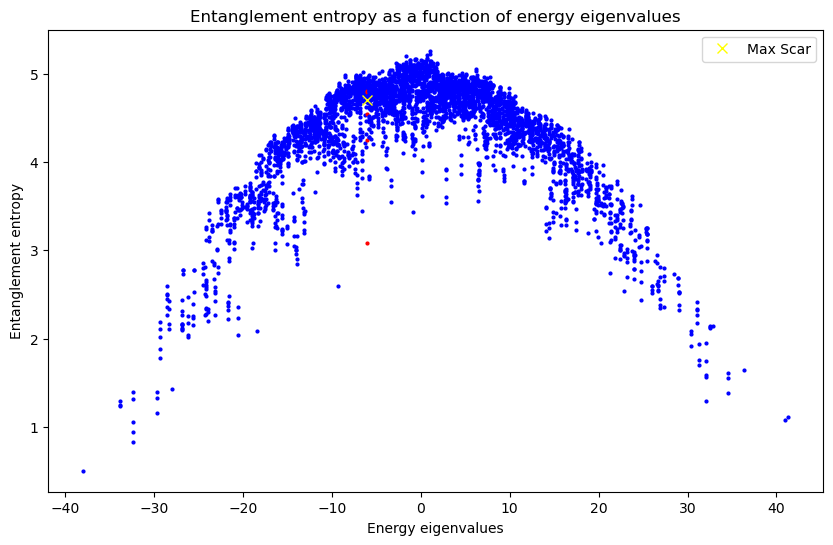

In [92]:
# Compute entanglement entropy for all eigenstates in the full Hilbert space
subsystem_size = N // 2
naive_entropies = [entanglement_entropy(eigenvectors[:, i], subsystem_size, N) for i in range(eigenvectors.shape[1])]

# Compute entanglement entropy for the max_scar wavefunction
max_scar_entropy = entanglement_entropy(max_scar, subsystem_size, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {naive_entropies[i]}')

print(f'Maximum scar entropy: {max_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
plt.figure(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues]


# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    plt.plot(eigenvalues[i], naive_entropies[i], 'o', color=color, markersize=2)

# Plot the maximum scar entropy in yellow
plt.plot(np.mean(red_eigenvalues), max_scar_entropy, 'x', color='yellow', markersize=7, label='Max Scar')

plt.xlabel('Energy eigenvalues')
plt.ylabel('Entanglement entropy')
plt.title('Entanglement entropy as a function of energy eigenvalues')
plt.legend()
plt.show()

Entropies of red points:
Index: 1266, Entropy: 4.796903469304959
Index: 1267, Entropy: 3.085208378924814
Index: 1268, Entropy: 4.808932481473969
Index: 1269, Entropy: 4.254512053088166
Index: 1270, Entropy: 4.54855091589067
Maximum scar entropy: 4.655780178645573


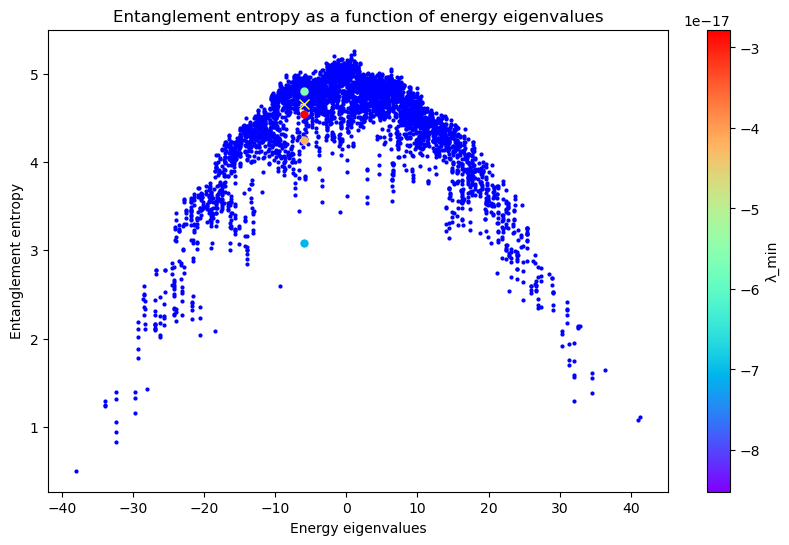

In [67]:
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices)))

# Compute entanglement entropy for all eigenstates in the full Hilbert space
subsystem_size = N // 2
naive_entropies = [entanglement_entropy(eigenvectors[:, i], subsystem_size, N) for i in range(eigenvectors.shape[1])]

# Compute entanglement entropy for the max_scar wavefunction
max_scar_entropy = entanglement_entropy(max_scar, subsystem_size, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {naive_entropies[i]}')

print(f'Maximum scar entropy: {max_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], naive_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices):
    handle, = ax.plot(eigenvalues[idx], naive_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(f'λ_min: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(red_eigenvalues), max_scar_entropy, 'x', color='yellow', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(max_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues[idx] for idx in red_indices]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label='λ_min')

ax.set_xlabel('Energy eigenvalues')
ax.set_ylabel('Entanglement entropy')
ax.set_title('Entanglement entropy as a function of energy eigenvalues')
#ax.legend(sorted_handles, sorted_labels)
plt.show()

Coeffs norm: 1.0
Entropy: 3.332120656967163
Coeffs: [ 0.3872919 +0.30678573j  0.28837168-0.08203076j -0.05528858-0.5244871j
 -0.21629673+0.51899314j  0.25429326-0.08398512j]
Coeffs norm: 0.9999999
Entropy: 3.3146941661834717
Coeffs: [ 0.3762859 +0.31594107j  0.2975761 -0.09178536j -0.0651145 -0.5131153j
 -0.22569335+0.52758265j  0.24364188-0.07378785j]
Coeffs norm: 1.0
Entropy: 3.293907403945923
Coeffs: [ 0.36488807+0.32470894j  0.30635008-0.10140471j -0.07484388-0.50150454j
 -0.23481011+0.53556263j  0.23276412-0.06353646j]
Coeffs norm: 1.0
Entropy: 3.2695603370666504
Coeffs: [ 0.3531518 +0.33308434j  0.31473574-0.11088741j -0.08447237-0.48955533j
 -0.24366197+0.54297966j  0.2216989 -0.05325073j]
Coeffs norm: 1.0
Entropy: 3.241495132446289
Coeffs: [ 0.34111503+0.3410208j   0.3227708 -0.12023322j -0.09399469-0.47723114j
 -0.25225914+0.5498611j   0.21047   -0.04294482j]
Coeffs norm: 0.99999994
Entropy: 3.209592342376709
Coeffs: [ 0.32881522+0.34841397j  0.33049265-0.1294455j  -0.10340711

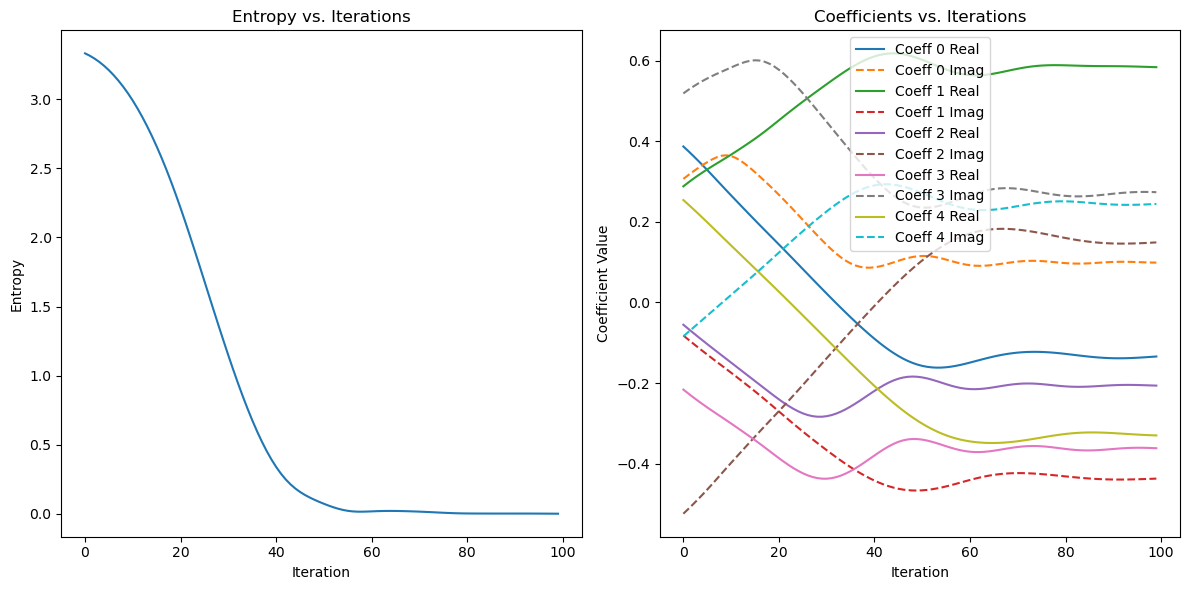

In [87]:
# find entropy min coeffs

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
params_real = torch.randn(5, requires_grad=True)
params_imag = torch.randn(5, requires_grad=True)

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history = []
entropy_history = []

# Optimization loop
num_iterations = 100
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, red_eigenvectors)
    
    # Compute entanglement entropy
    entropy = entanglement_entropy_torch(psi, N // 2, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {entropy.item()}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history.append(coeffs.detach().cpu().numpy())
    entropy_history.append(entropy.item())

# Final optimized coefficients
optimized_coeffs = torch.complex(params_real, params_imag)
optimized_coeffs = optimized_coeffs / torch.norm(optimized_coeffs)

print("Optimized coefficients:", optimized_coeffs)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(entropy_history)
plt.xlabel('Iteration')
plt.ylabel('Entropy')
plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history = np.array(coeffs_history)
for i in range(coeffs_history.shape[1]):
    plt.plot(coeffs_history[:, i].real, label=f'Coeff {i} Real')
    plt.plot(coeffs_history[:, i].imag, label=f'Coeff {i} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Coeffs norm: 1.0
Entropy: -3.0573408603668213
Coeffs: [-0.6502595 -0.02798569j -0.08095882-0.64185584j -0.22271718-0.2600621j
 -0.09286735-0.02919603j  0.08344411+0.15547106j]
Coeffs norm: 0.99999994
Entropy: -3.0994060039520264
Coeffs: [-0.6568889 -0.03779177j -0.09049448-0.6286303j  -0.23152916-0.26868343j
 -0.08244433-0.03899594j  0.09296709+0.14472844j]
Coeffs norm: 1.0
Entropy: -3.1366450786590576
Coeffs: [-0.66286343-0.04641533j -0.09974137-0.6149934j  -0.24010935-0.27699906j
 -0.07201891-0.04866531j  0.10203563+0.13396011j]
Coeffs norm: 1.0
Entropy: -3.1693308353424072
Coeffs: [-0.66831136-0.05132039j -0.10854989-0.6011708j  -0.24852087-0.28505546j
 -0.06163069-0.0581741j   0.11020744+0.12324487j]
Coeffs norm: 1.0
Entropy: -3.1981356143951416
Coeffs: [-0.6733899 -0.05071381j -0.11673865-0.5874021j  -0.2568408 -0.29291883j
 -0.05131375-0.0675037j   0.11685108+0.1126602j ]
Coeffs norm: 0.99999994
Entropy: -3.22367525100708
Coeffs: [-0.6781218 -0.04630228j -0.12408581-0.57379436j -

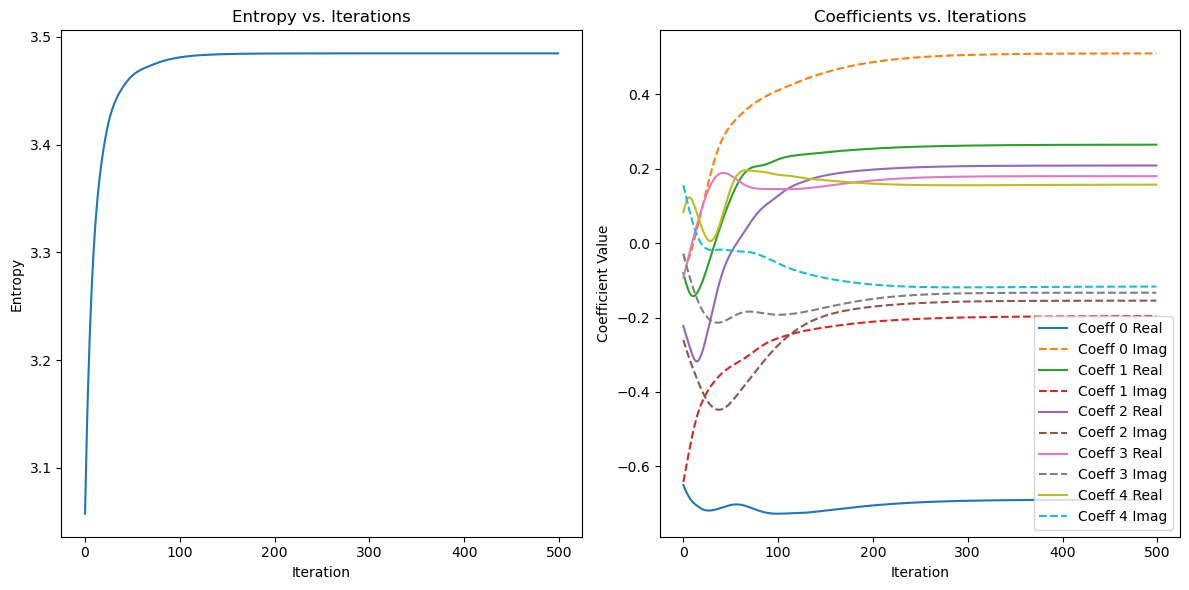

In [89]:
# now find entropy max coeffs

# Initialize parameters for the coefficients with all values equal
#params_real = torch.full((5,), 1/np.sqrt(10), requires_grad=True)
#params_imag = torch.full((5,), 1/np.sqrt(10), requires_grad=True)

# Initialize parameters for the coefficients with random values
params_real = torch.randn(5, requires_grad=True)
params_imag = torch.randn(5, requires_grad=True)

# Normalize the parameters to ensure the norm is 1
with torch.no_grad():
    norm = torch.norm(torch.complex(params_real, params_imag))
    params_real /= norm
    params_imag /= norm

# Define the optimizer
optimizer = optim.Adam([params_real, params_imag], lr=0.01)

# Lists to store the values of parameters and entropy
coeffs_history_max = []
entropy_history_max = []

# Optimization loop
num_iterations = 500
for _ in range(num_iterations):
    optimizer.zero_grad()
    
    # Combine real and imaginary parts for the coefficients
    coeffs = torch.complex(params_real, params_imag)
    
    # Normalize coefficients to project them onto the unit sphere
    coeffs = coeffs / torch.norm(coeffs)
    
    # Compute psi
    psi = linear_combination(coeffs, red_eigenvectors)
    
    # Compute - entanglement entropy
    entropy = - entanglement_entropy_torch(psi, N // 2, N) # it would be better to compute the outer product of the state before the optimization loop. but optimization is not taking too long so it's ok for now
    
    # Backpropagation
    entropy.backward()
    optimizer.step()
    
    # Normalize parameters again to ensure they stay on the unit sphere
    with torch.no_grad():
        norm = torch.norm(torch.complex(params_real, params_imag))
        params_real /= norm
        params_imag /= norm
    print("Coeffs norm:", torch.norm(torch.complex(params_real, params_imag)).detach().cpu().numpy())
    
    print(f'Entropy: {entropy.item()}')
    print(f'Coeffs: {coeffs.detach().cpu().numpy()}')

    # Store the values of parameters and entropy
    coeffs_history_max.append(coeffs.detach().cpu().numpy())
    entropy_history_max.append(entropy.item())

# Final optimized coefficients
optimized_coeffs_max = torch.complex(params_real, params_imag)
optimized_coeffs_max = optimized_coeffs_max / torch.norm(optimized_coeffs_max)

print("Optimized coefficients:", optimized_coeffs_max)

# Plot the value of parameters and entropy as a function of num_iterations
plt.figure(figsize=(12, 6))

# Plot entropy
plt.subplot(1, 2, 1)
plt.plot(np.abs(entropy_history_max))
plt.xlabel('Iteration')
plt.ylabel('Entropy')
plt.title('Entropy vs. Iterations')

# Plot coefficients
plt.subplot(1, 2, 2)
coeffs_history_max = np.array(coeffs_history_max)
for i in range(coeffs_history_max.shape[1]):
    plt.plot(coeffs_history_max[:, i].real, label=f'Coeff {i} Real')
    plt.plot(coeffs_history_max[:, i].imag, label=f'Coeff {i} Imag', linestyle='--')
plt.xlabel('Iteration')
plt.ylabel('Coefficient Value')
plt.title('Coefficients vs. Iterations')
plt.legend()

plt.tight_layout()
plt.show()

Entropies of red points:
Index: 1266, Entropy: 4.796903469304959
Index: 1267, Entropy: 3.085208378924814
Index: 1268, Entropy: 4.808932481473969
Index: 1269, Entropy: 4.254512053088166
Index: 1270, Entropy: 4.54855091589067
Maximum scar entropy: 0.0014957470967341697


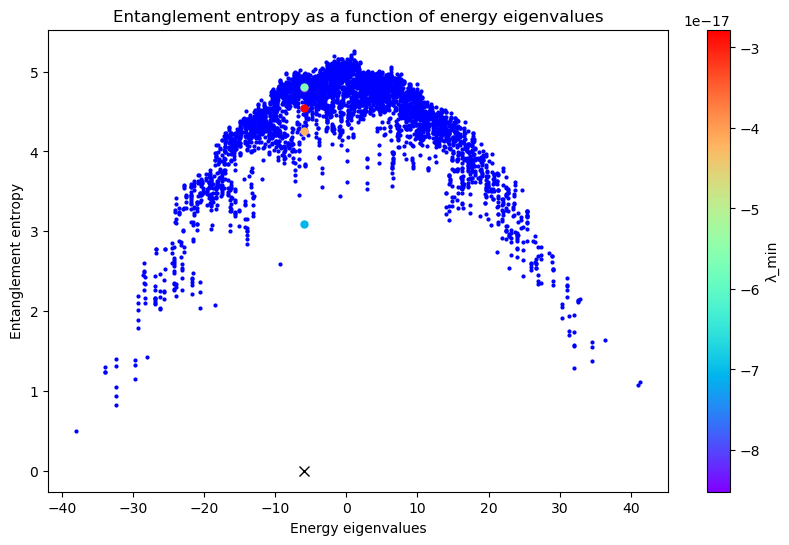

In [ ]:
# Compute the max_scar wavefunction using the optimized coefficients (min entropy)
max_scar = linear_combination_np(coeffs_history[-1], red_eigenvectors)
# Define a list of colors for red points
red_colors = plt.cm.rainbow(np.linspace(0, 1, len(red_indices)))

# Compute entanglement entropy for all eigenstates in the full Hilbert space
subsystem_size = N // 2
naive_entropies = [entanglement_entropy(eigenvectors[:, i], subsystem_size, N) for i in range(eigenvectors.shape[1])]

# Compute entanglement entropy for the max_scar wavefunction
max_scar_entropy = entanglement_entropy(max_scar, subsystem_size, N)

# Print entropies of red points only
print("Entropies of red points:")
for i in red_indices:
    print(f'Index: {i}, Entropy: {naive_entropies[i]}')

print(f'Maximum scar entropy: {max_scar_entropy}')

# Plot entanglement entropy as a function of energy eigenvalues
fig, ax = plt.subplots(figsize=(10, 6))

# Highlight points with y-component less than the threshold in red
colors = ['red' if y < threshold else 'blue' for y in min_eigenvalues]

# Plot entanglement entropy with highlighted points
for i, color in enumerate(colors):
    ax.plot(eigenvalues[i], naive_entropies[i], 'o', color=color, markersize=2)

# Collect handles and labels for the legend
handles = []
labels = []

# Plot each red point with a different color and collect handles and labels
for i, idx in enumerate(red_indices):
    handle, = ax.plot(eigenvalues[idx], naive_entropies[idx], 'o', color=red_colors[i], markersize=5)
    handles.append(handle)
    labels.append(f'λ_min: {float(min_eigenvalues[idx]):.2e}, Entropy: {naive_entropies[idx]:.2f}')

# Plot the maximum scar entropy in yellow and add to handles and labels
max_scar_handle, = ax.plot(np.mean(eigenvalues[red_indices]), max_scar_entropy, 'x', color='black', markersize=7)
handles.append(max_scar_handle)
labels.append('Max Scar, Entropy: {:.2f}'.format(max_scar_entropy))

# Sort handles and labels by lambda min
sorted_handles_labels = sorted(zip(handles, labels), key=lambda hl: float(hl[1].split(': ')[1].split(',')[0]) if 'λ_min' in hl[1] else float('inf'))
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Filter min_eigenvalues to include only those corresponding to red_indices
filtered_min_eigenvalues = [min_eigenvalues[idx] for idx in red_indices]

# Create a color bar for the red points using filtered min_eigenvalues
norm = Normalize(vmin=min(filtered_min_eigenvalues), vmax=max(filtered_min_eigenvalues))
sm = ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, label='λ_min')

ax.set_xlabel('Energy eigenvalues')
ax.set_ylabel('Entanglement entropy')
ax.set_title('Entanglement entropy as a function of energy eigenvalues')
#ax.legend(sorted_handles, sorted_labels)
plt.show()

In [ ]:
#now find 4spins rdm for the max scarred state with optimized coefficients

In [60]:
#find a 4/5 spins charge commuting with the rdm.